# Machine Learning Prototype for Customer Churn Prediction

This notebook contains the initial prototype for loading, preprocessing, and modeling customer churn data from multiple datasets.  
The goal is to establish a baseline churn prediction model and prepare for multi-dataset feature engineering.


# Data Loading  

We start by importing necessary libraries and loading the Telco Customer Churn dataset into a pandas DataFrame.
We then inspect the shape, data types, and preview the first few rows to understand the data structure.


In [10]:
import pandas as pd
import numpy as np

# Load dataset
file_path = '/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

# Basic info
print("Data Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())


Data Shape: (7043, 21)

Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

First 5 rows:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male    

*The dataset contains 7043 rows and 21 columns with mixed data types including numerical and categorical features.*

# Missing Data and Empty String Checks

Next, we check for any missing values or empty strings which could represent missing data in object-type columns.

In [11]:
# Check for missing values (NaN) in each column
missing_summary = df.isnull().sum()

# Filter to columns that have any missing values (>0)
missing_columns = missing_summary[missing_summary > 0]

if missing_columns.empty:
    print("\nMissing values per column:\nNo missing values found in any column.")
else:
    print("\nMissing values per column:\n", missing_columns)

# Check for empty strings in columns with object data type (could be missing data)
empty_str_summary = (df.select_dtypes(include='object') == '').sum()

# Filter to columns with any empty strings (>0)
empty_string_columns = empty_str_summary[empty_str_summary > 0]

if empty_string_columns.empty:
    print("\nEmpty strings per object column:\nNo empty strings found in any object column.")
else:
    print("\nEmpty strings per object column:\n", empty_string_columns)





Missing values per column:
No missing values found in any column.

Empty strings per object column:
No empty strings found in any object column.


*No missing values or empty strings were detected, indicating the dataset is mostly complete.*

# Outlier Detection in Numeric Columns

We identify potential outliers in numeric columns using the Interquartile Range (IQR) method, which flags values outside 1.5 times the IQR from Q1 and Q3.

In [12]:
# Numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", numeric_cols)

def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers.shape[0]

for col in numeric_cols:
    outlier_count = detect_outliers_iqr(df, col)
    print(f"Outliers detected in {col}: {outlier_count}")



Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Outliers detected in SeniorCitizen: 1142
Outliers detected in tenure: 0
Outliers detected in MonthlyCharges: 0


*1142 outliers were detected in the SeniorCitizen column; no outliers detected in tenure or MonthlyCharges.*

# Converting and Cleaning TotalCharges Column

The TotalCharges column is currently an object type due to some non-numeric values. We convert it to numeric, coercing errors to NaN, then handle those missing values, accordingly.

In [13]:
# Convert TotalCharges to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Count invalid conversions to NaN
num_invalid = df['TotalCharges'].isna().sum()
print(f"TotalCharges invalid/missing values after conversion: {num_invalid}")

# Drop rows with NaN in TotalCharges (few rows)
df_clean = df.dropna(subset=['TotalCharges']).copy()

# Summary statistics after cleaning
print(df_clean['TotalCharges'].describe())


TotalCharges invalid/missing values after conversion: 11
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


*11 rows had invalid or missing TotalCharges values and were removed for now.*

# Handling Remaining Missing Values

To ensure a clean dataset, we fill any missing numeric values with the mean and categorical values with the mode.

In [14]:
# Fill missing TotalCharges with mean
mean_total_charges = df_clean['TotalCharges'].mean()
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(mean_total_charges)

# Fill missing categorical values with mode
cat_cols = df_clean.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    if df_clean[col].isnull().any():
        mode_val = df_clean[col].mode()[0]
        df_clean[col] = df_clean[col].fillna(mode_val)

# Fill missing numeric values (excluding TotalCharges) with mean
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in num_cols:
    if df_clean[col].isnull().any():
        mean_val = df_clean[col].mean()
        df_clean[col] = df_clean[col].fillna(mean_val)

# Confirm no missing values remain
final_missing = df_clean.isnull().sum()
print("Final missing values count:\n", final_missing[final_missing > 0])


Final missing values count:
 Series([], dtype: int64)


# Correlation Analysis of Numeric Features

This block calculates the correlation matrix for all numeric columns in the cleaned dataset.
It visualizes the correlations using a heatmap to help identify feature pairs with strong linear relationships.
Additionally, it lists all pairs of features with correlation magnitude above 0.7, which might indicate redundancy or opportunities for feature engineering.

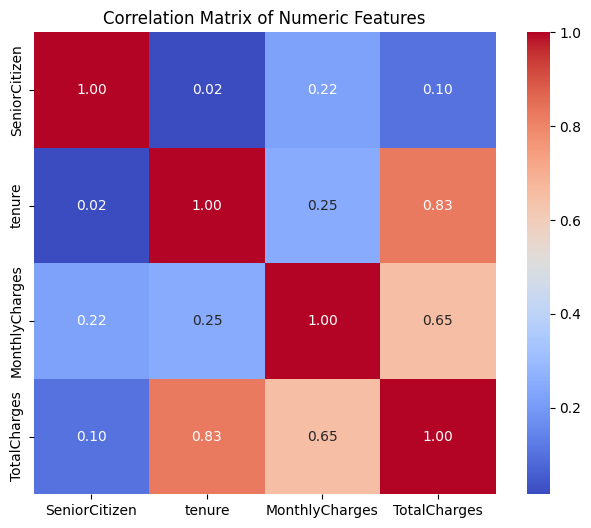

Strongly correlated feature pairs (>|0.7|):
TotalCharges and tenure: correlation = 0.83


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix for numeric columns
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df_clean[numeric_cols].corr()

# Display correlation matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Optionally, print pairs with high correlation (> 0.7 or < -0.7)
threshold = 0.7
strong_corrs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            strong_corrs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_value))

print("Strongly correlated feature pairs (>|0.7|):")
for feat1, feat2, corr_val in strong_corrs:
    print(f"{feat1} and {feat2}: correlation = {corr_val:.2f}")


*The correlation matrix shows tenure and TotalCharges are strongly positively correlated (0.83), and MonthlyCharges and TotalCharges have a moderate positive correlation (0.65). SeniorCitizen has weak correlations with all other features. These insights suggest tenure and TotalCharges may provide overlapping information, so feature engineering or dimensionality reduction could improve model performance.*